### LSTM Network 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm  import tqdm_notebook #used for loading bar (e.g. to visualise how long an operation is taking)
from tensorflow.keras.datasets import imdb

In [2]:
(X_train, Y_train), (X_test, Y_test) = imdb.load_data()

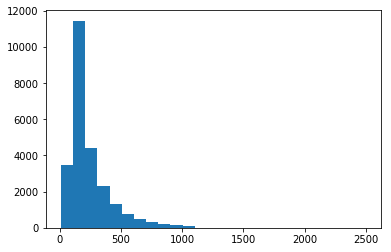

In [3]:
def length_stats(X):
    lengths = []
    for x in X:
        lengths.append(len(x))
    plt.hist(lengths,bins=25)
    plt.show()
length_stats(X_train)

max_length = 300

In [4]:
idx_to_word = {(v+3):k for k,v in imdb.get_word_index().items()}
idx_to_word.update({0:"<PAD>", 1: "<START>", 2: "<UNK>",3:"<UNUSED>"}) #first 3 indices are special tokens 

vocab_size = np.max(list(idx_to_word.keys()))
print(vocab_size)
#this is a helper function - good to debug performance of model during training
def print_review(x):
    text = ""
    for idx in x:
        text += idx_to_word.get(idx, "<UNK>") + " " #if word not in dictionary it is unknown
    return text

88587


In [5]:
def sigmoid(z):
    return 1.0/(1+np.exp(-z))


def initialise_parameters(n_a,n_x):
    Wg, bg = np.random.rand(3*n_a,n_a+n_x), np.random.rand(3*n_a, 1)
    Wc, bc = np.random.rand(n_a,n_a+n_x), np.random.rand(n_a, 1)
    Wy, by = np.random.rand(1,n_a), np.random.rand(1, 1)
    a0 = c0 = np.zeros((n_a,1))
    parameters = {"Wg": Wg,"Wc": Wc,"Wy": Wy,"bg": bg, "bc": bc,"by": by, "a0": a0, "c0":c0}
    return parameters
    
def forward_step(a_prev, x, c_prev, parameters):
    n_a = a_prev.shape[0]
    input_concat = np.concatenate((a_prev, x),axis=0)
    IFO_gates = sigmoid(parameters["Wg"].dot(input_concat)+parameters["bg"])
    c_candidate = np.tanh(parameters["Wc"].dot(input_concat)+parameters["bc"])
    c_next = IFO_gates[:n_a]*c_candidate + IFO_gates[n_a:2*n_a]*c_prev
    a_next = IFO_gates[2*n_a:]*np.tanh(c_next)
    cache = (a_next, c_next, input_concat, c_prev, c_candidate,IFO_gates)
    return a_next, c_next, cache


def backward_step(dA_next, dC_next,cache,parameters):
    (a_next, c_next, input_concat, c_prev, c_candidate,IFO_gates) = cache
    n_a, m = a_next.shape
    
    dC_next += dA_next* (IFO_gates[2*n_a:]*(1-np.tanh(c_next)**2))
    
    dC_prev = dC_next * IFO_gates[n_a:2*n_a]
    dC_candidate =  dC_next * IFO_gates[:n_a]
    
    dIFO_gates = np.zeros_like(IFO_gates)
    dIFO_gates[:n_a] = dC_next * c_candidate 
    dIFO_gates[n_a:2*n_a]= dC_next * c_prev
    dIFO_gates[2*n_a:] = dA_next * np.tanh(c_next)

    dZ_gate =  dIFO_gates* (IFO_gates*(1-IFO_gates))   
    dA_prev =  (parameters["Wg"].T).dot(dZ_gate)[:n_a]
    dWg = (1/m)*dZ_gate.dot(input_concat.T)
    dbg = (1/m)*np.sum(dZ_gate,axis=1, keepdims=True)
    
    dZ_c = dC_candidate * (1-c_candidate**2)
    dA_prev +=  (parameters["Wc"].T).dot(dZ_c)[:n_a]
    dWc = (1/m)*dZ_c.dot(input_concat.T)
    dbc = (1/m)*np.sum(dZ_c,axis=1, keepdims=True)  
    
    return dA_prev, dC_prev, dWg, dbg, dWc, dbc



In [6]:
def forward_prop(X, parameters):
    m, _, Tx = X.shape
    a_prev = np.repeat(parameters["a0"],m, axis=1)
    c_prev = np.repeat(parameters["c0"],m, axis=1)
    caches= []
    for t in range(Tx):
        xt = np.squeeze(X[:,:,t]).T #so 2D matrix n_x, m
        a_prev, c_prev, cache = forward_step(a_prev,xt , c_prev, parameters)
        caches.append(cache)
    y_pred = sigmoid(parameters["Wy"].dot(a_prev)+parameters["by"])
    return y_pred, caches


def backprop(X,y, y_pred, parameters, caches,lambd):
    m, _, Tx = X.shape
    grads = {}
    
    
    dZ_pred = (y_pred-y) 
    dA =  (parameters["Wy"].T).dot(dZ_pred)
    grads["dWy"] = (1/m)*dZ_pred.dot(caches[Tx-1][0].T) #this is A<t>
    grads["dby"] = (1/m)*np.sum(dZ_pred,axis=1, keepdims=True)
    
    dC = np.zeros_like(dA)
    
    grads["dWg"] = np.zeros_like(parameters["Wg"])
    grads["dbg"] = np.zeros_like(parameters["bg"])
    grads["dWc"] = np.zeros_like(parameters["Wc"])
    grads["dbc"] = np.zeros_like(parameters["bc"])
    
    
    for t in reversed(range(Tx)):
        (dA, dC, dWg, dbg, dWc, dbc) = backward_step(dA, dC, caches[t],parameters)
        grads["dWg"] += dWg
        grads["dbg"] += dbg
        grads["dWc"] += dWc
        grads["dbc"] += dbc
    
    grads["da0"] = (1/m)*np.sum(dA,axis=1,keepdims=True)
    grads["dc0"] = (1/m)*np.sum(dC,axis=1,keepdims=True)
    
    #regularisation term
    for key in grads:
        if "W" in key:
            grads[key]+= (lambd/m)*parameters[key[1:]] 
    
    return grads


In [7]:
def loss_function(y_pred,y, parameters, lambd):
    m = y.shape[0]
    cost = (-1/m)*np.sum(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))
    
    regularisation_term = 0
    for key in parameters:
        if "W" in key:
            regularisation_term += np.sum(np.square(parameters[key]))
    
    regularised_cost = cost + (lambd/(2*m))*regularisation_term
    
    return regularised_cost


In [8]:
def accuracy(y_pred,y):
    preds = np.rint(y_pred) #round to int
    return np.mean(np.equal(preds,y).astype(int))

In [9]:
def backprop_checker(parameters,grads, x, y,lambd):
    epsilon = 1e-7
    rel_threshold = 1e-4
    num_sample = 10
    flag = True #if backprop is correct
    print("Checking gradients...")
    for param in parameters.keys(): 
        print("Checking: " + param)
        dims = parameters[param].shape
        
        
        num_grad = 0
        backprop_grad = 0
        
        for _ in range(num_sample): #sample 10 neurons
            idx = np.zeros(len(dims))
            for i in range(len(dims)):
                idx[i] = np.random.randint(0,dims[i])
            idx = tuple(idx.astype(int))

            parameters[param][idx]= parameters[param][idx] + epsilon
            y_pred_plus = forward_prop(x,parameters)[0]
            J_plus = loss_function(y_pred_plus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx] - 2*epsilon

            y_pred_minus = forward_prop(x,parameters)[0]

            J_minus = loss_function(y_pred_minus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx]+ epsilon

            num_grad += (J_plus-J_minus)/(2*epsilon)
            backprop_grad += grads["d"+param][idx]
            
            
        num_grad/=num_sample
        backprop_grad/=num_sample
        rel_error = abs((num_grad-backprop_grad)/num_grad)
        if rel_error>rel_threshold:
            #print("J_plus: "+ str(J_plus))
            #print("J_minus: "+ str(J_minus))
            print("Numerical grad:" + str(num_grad))
            print("Backprop grad:" + str(backprop_grad))
            print("Relative error: " + str(rel_error))
            flag = False
            print("Backprop calculation incorrect")
    print("Gradient check complete")
    assert(flag) #if not the backprop is massively out so kill training

In [10]:
%matplotlib notebook
def train_model(X_train, Y_train, X_dev, Y_dev,num_epochs, batch_size,lambd,learning_rate,num_hidden_units=512, parameters = None ):
    train_costs = []
    train_evals = []
    dev_evals = []
    fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(10, 3))
    
    ax1.set_xlabel('Number of iterations')
    ax1.set_ylabel('Error')
    ax1.set_title('Training Set Error')
    
    ax2.set_xlabel('Number of iterations')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Set Accuracy')
    
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Dev Set Accuracy')

    plt.tight_layout()
    plt.ion()

    fig.show()
    fig.canvas.draw()
    
    if parameters==None:
        parameters = initialise_parameters(num_hidden_units, X_train.shape[1])
        
    for epoch in tqdm_notebook(range(num_epochs),total=num_epochs):
        #cycle through the entire training set in batches
        for i in tqdm_notebook(range(0,X_train.shape[0]//batch_size), total =X_train.shape[0]//batch_size, desc = "Minibatch number"):
            
            
            #get the next minibatch to train on
            X_train_minibatch = X_train[i*batch_size:(i+1)*batch_size]
            Y_train_minibatch = Y_train[:,i*batch_size:(i+1)*batch_size]
            #perform one cycle of forward and backward propagation to get the partial derivatives w.r.t. the weights
            #and biases. Calculate the cost - used to monitor training
            y_pred, caches = forward_prop(X_train_minibatch,parameters)
            minibatch_cost = loss_function(y_pred,Y_train_minibatch,parameters,lambd)
            minibatch_grads = backprop(X_train_minibatch,Y_train_minibatch,y_pred,parameters, caches,lambd)
            
            #check backprop calculations - comment out once satisfied
           # backprop_checker(parameters,minibatch_grads, X_train_minibatch, Y_train_minibatch,lambd)
            
            #update the parameters using gradient descent
            for param in parameters.keys():
                parameters[param] = parameters[param] - learning_rate*minibatch_grads["d"+param]
            
            #visualise error
            train_costs.append(minibatch_cost)
            ax1.plot(train_costs)
            fig.canvas.draw()
            
            
            train_eval_metric = accuracy(y_pred,Y_train_minibatch)
            train_evals.append(train_eval_metric)
            ax2.plot(train_evals)
            fig.canvas.draw()
            
            #periodically output an update on the current cost and performance on the dev set for visualisation
            if(i%100 == 0):
                print("Training set error: "+ str(minibatch_cost))
                print("Training set accuracy: "+ str(train_eval_metric))
                y_dev_pred,_ = forward_prop(X_dev,parameters)
                dev_eval_metric = accuracy(y_dev_pred,Y_dev)
                dev_evals.append(dev_eval_metric)
                print("Accuracy on dev set: "+ str(dev_eval_metric))
                ax3.plot(dev_evals)
                fig.canvas.draw()
    print("Training complete!")
    #return the trained parameters 
    return parameters

In [19]:
embedding_size = 128

E = np.random.rand(vocab_size,embedding_size) #embedding matrix

def preprocess_input(X,Y, E=E, max_length=max_length):
    X_processed = np.zeros((X.shape[0], E.shape[1], max_length))
    for i in range(X.shape[0]):
        x_clipped = X[i][:max_length]
        X_processed[i,:,:len(x_clipped)] = E[x_clipped, :].T
    Y_processed = np.expand_dims(Y, axis=0)
    return X_processed,Y_processed

In [20]:
def sample_context_target(X):
    i = np.random.randint(X.shape[0])
    j = np.random.randint(len(X[i]))
    
    context = X[i][j]
    target = np.random.choice(X[i][max(0,(j-3)):(j+3)])
    
    return context, target

def negative_targets(k):
    return np.random.choice(list(imdb.get_word_index().values()), size=k)

def relu(x, deriv=True):
    if deriv:
        return x>0
    else:
        return np.multiply(x,x>0)
def sigmoid(z):
    return 1.0/(1+np.exp(-z))


def sampled_softmax(E,k, X_train,num_iters=int(5000), learning_rate=1e-3):
    
    W_em1 = np.random.rand(256,embedding_size)
    b_em1 = np.random.rand(256,1)
    W_em2 = np.random.rand(vocab_size, 256)
    b_em2 = np.random.rand(vocab_size, 1)
    
    train_costs = []
    fig, ax = plt.subplots(1,1,figsize=(10, 4))
    
    ax.set_xlabel('100s of iterations')
    ax.set_ylabel('Error')
    ax.set_title('Training Set Error')
    
    plt.tight_layout()
    plt.ion()

    fig.show()
    fig.canvas.draw()
    
    cost=0
    
    for i in tqdm_notebook(range(num_iters), total=num_iters):
        
        context, target = sample_context_target(X_train)
        neg_targets =  negative_targets(k)

        samples = [target] + list(neg_targets)
        emb = E[[context],:].T  
        z1 = W_em1.dot(emb)+b_em1
        a1 = relu(z1)
        z2 = W_em2[samples,:].dot(a1)+b_em2[samples]
        y_pred = sigmoid(z2)

        y = np.zeros_like(y_pred)
        y[0,:] = 1
        samples = [target] + list(neg_targets)
        
        cost += -1* (np.sum(np.log(y_pred[0])) + np.sum(np.log(1-y_pred[1:])))
    
        #visualise error
        if i%100==0:
            print(cost/100)
            print(y_pred)
            print(print_review([context]))
            print(print_review(samples))
            train_costs.append(cost/100)
            ax.plot(train_costs)
            fig.canvas.draw()
            cost=0
        
        
        dz2 = y_pred - y
        db_em2 = dz2
        dW_em2= dz2.dot(a1.T)

        da1 = W_em2[samples,:].T.dot(dz2)
        dz1 = da1*relu(z1,deriv=True)

        db_em1 = dz1
        dW_em1 = dz1.dot(emb.T)
        demb = W_em1.T.dot(dz1)

        W_em2[samples] -= learning_rate*dW_em2
        b_em2[samples] -= learning_rate*db_em2

        W_em1 -= learning_rate*dW_em1
        b_em1 -= learning_rate*db_em1

        E[[context],:]  -= learning_rate*demb.T
    return E

<IPython.core.display.Javascript object>


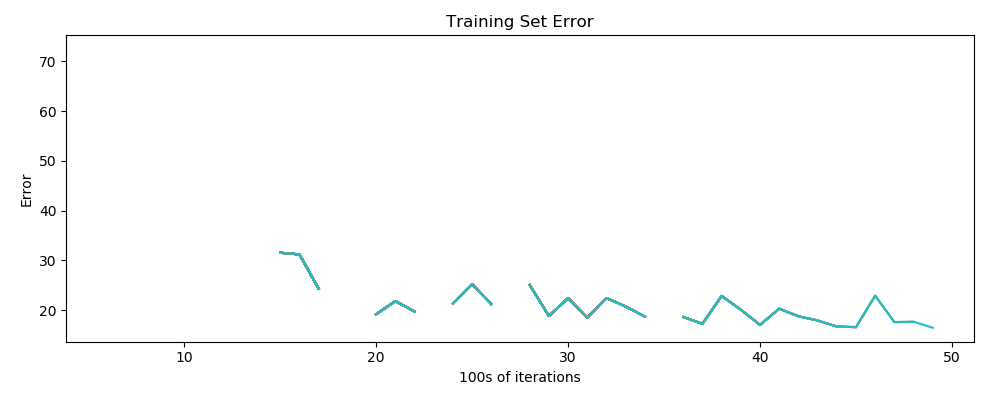

/home/mukulrathi/miniconda3/envs/testenv/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log


inf
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
her 
achieving told miaoooou duping servant homegirls disposal street kiri stupider tacones deterred writhed playfulness mystifying editor 
inf
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
the 
of caretaker flowered croats fraser's tenderness interrogates finney dirtiest passe wiiliams disneyfied fastidious characteristic marielle mikhail 
inf
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
but 
educate kill'em gallagher leafy coffins lawsuit ignited godby usa vaunted natalie's lavitz installment vivica riddick demises 
inf
[[0.99941517]
 [0.9993232 ]
 [0.99992577]
 [0.99990841]
 [0.99938352]
 [0.99985611]
 [0.99978674]
 [0.9990904 ]
 [0.99929206]
 [0.99968088]
 [0.999913  ]
 [0.99968244]
 [0.99893154]
 [0.99949609]
 [0.99995121]
 [0.99993325]]
and 
lots shiktak odysseus' custom truckers

21.334696677582652
[[0.88467372]
 [0.88992559]
 [0.88746242]
 [0.86252616]
 [0.82270287]
 [0.88305925]
 [0.7712065 ]
 [0.84469823]
 [0.94634338]
 [0.90596973]
 [0.8732341 ]
 [0.93585668]
 [0.92598392]
 [0.96405981]
 [0.89355908]
 [0.85926246]]
characters 
things secor seminarians 'ziggy' reticence tech coated kira asthetics austrailan figure's sagely quarreled stultified shue's lam 
25.21543805105989
[[0.53523266]
 [0.71288174]
 [0.65329494]
 [0.7274261 ]
 [0.57640886]
 [0.68446463]
 [0.64159623]
 [0.62716778]
 [0.64957733]
 [0.66256102]
 [0.69971218]
 [0.5063315 ]
 [0.62401132]
 [0.54605557]
 [0.70016414]
 [0.62357247]]
first 
all constabulary crassness godyes' sulley ama shanty 'sacrifice' 430 assistants extras calming brillent preordained verucci proclaiming 
21.210368964222322
[[0.79310017]
 [0.85598025]
 [0.83331661]
 [0.51226224]
 [0.68452031]
 [0.7055983 ]
 [0.82947625]
 [0.59416303]
 [0.71237847]
 [0.80434739]
 [0.68566369]
 [0.74403504]
 [0.65831708]
 [0.80053555]
 [0.7231100

22.90451009996591
[[0.57649277]
 [0.73039165]
 [0.6100851 ]
 [0.65726469]
 [0.52161683]
 [0.72858875]
 [0.6581293 ]
 [0.73077541]
 [0.59284355]
 [0.55424638]
 [0.73094612]
 [0.59732472]
 [0.72871423]
 [0.69232756]
 [0.65767934]
 [0.72228637]]
is 
government plank timeliness encumbering advertise demonicly stately bodied harmonic belies julia's unformed mcmahon elkaim hairless flashed 
17.612793998349336
[[0.59543991]
 [0.50926148]
 [0.50490067]
 [0.64999096]
 [0.71953868]
 [0.56977965]
 [0.67242528]
 [0.57249239]
 [0.52458854]
 [0.53568313]
 [0.72807926]
 [0.68634127]
 [0.61109271]
 [0.59366431]
 [0.59648518]
 [0.67551648]]
of 
ten ofter burning unutterable phantasmogoric ehm jocelyn drumbeat ipcress manèges 26th wittgenstein inversely shillin' choir epidemy 
17.683186509752144
[[0.99958722]
 [0.99996928]
 [0.99656072]
 [0.99880843]
 [0.99994542]
 [0.99947236]
 [0.99993661]
 [0.99951076]
 [0.999625  ]
 [0.99981994]
 [0.99995051]
 [0.99884678]
 [0.99445323]
 [0.99993435]
 [0.99971512]
 

In [21]:
E = sampled_softmax(E,15, X_train)

In [14]:
from sklearn.manifold import TSNE
E_embedded = TSNE(n_components=2).fit_transform(E[:1000]) #see if any clusters in first 1000 words of vocab


<IPython.core.display.Javascript object>


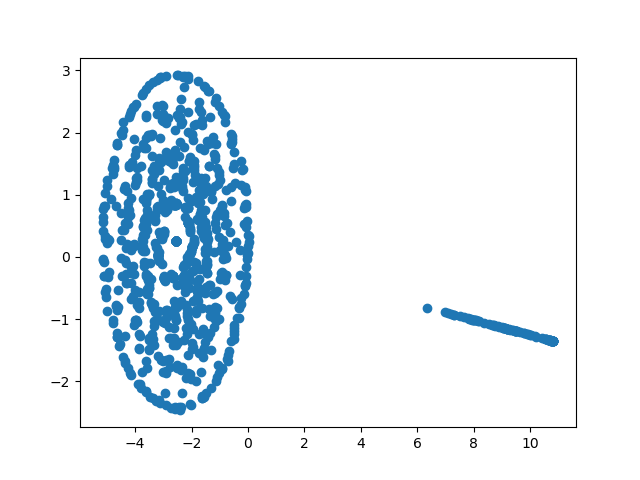

In [17]:
plt.ioff()
plt.scatter(E_embedded[:,0],E_embedded[:,1])
plt.show()